###Installing Library

In [1]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q transformers[torch] accelerate -U
!pip install -q accelerate -U
!pip install -q datasets
!pip install -q gensim
!pip install -q evaluate
!pip install -q imblearn
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00


###Import Library

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load as load_metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE
import os
os.environ["WANDB_DISABLED"] = "true"
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

###Read Dataset and load Word2Vec

In [3]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

In [4]:
df_test1 = pd.read_csv("/content/pilpres_test_clean.csv")
# # df_test2 = pd.read_csv("test_data_2.csv")
# # df_test3 = pd.read_csv("test_data_3.csv")

In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [6]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")

Downloading...
From (original): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3
From (redirected): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3&confirm=t&uuid=96619825-6a20-496b-9a53-6ab3051d8bc8
To: /content/model_w2v.zip
100%|██████████| 2.56G/2.56G [00:19<00:00, 129MB/s]


Extracting File...
Done.


In [7]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [8]:
x_train = df['Text'].astype(str)
y_train = df['Label']

In [9]:
x_test1 = df_test1['Text'].astype(str)
y_test1 = np.array(df_test1['Label'])

In [10]:
# x_test2 = df_test2['Text']
# y_test2 = np.array(df_test2['Label'])

In [11]:
# x_test3 = df_test3['Text']
# y_test3 = np.array(df_test3['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [12]:
# # # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [13]:
# Define the model architectures
#max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
num_words = 100000
embedding_dim = word_embeddings.vector_size
features_logits_count = 2 # Define features_logits_count here based on the output shape of IndoBERT (2 classes)

In [14]:
# Tokenization
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1)
# x_test_sequences2 = tokenizer.texts_to_sequences(x_test2)
# x_test_sequences3 = tokenizer.texts_to_sequences(x_test3)

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')
# x_test_padded2 = pad_sequences(x_test_sequences2, maxlen=max_sequence_length, padding='post')
# x_test_padded3 = pad_sequences(x_test_sequences3, maxlen=max_sequence_length, padding='post')


In [15]:
# Create word index
word_index_keras = tokenizer.word_index
print(f"Full vocabulary size (Word2Vec): {len(word_embeddings.wv.index_to_key)}")
print(f"Tokenizer vocabulary size (Top K): {len(word_index_keras)}")

Full vocabulary size (Word2Vec): 447356
Tokenizer vocabulary size (Top K): 8625


In [16]:
# Create embedding matrix
vocab_size = min(len(word_index_keras) + 1, num_words)

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index_keras.items():
    if i >= vocab_size:
        continue
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (8626, 768)


In [17]:
print(f"Input shape: {x_train_padded.shape}")

Input shape: (6274, 43)


####Oversampling with BorderlineSMOTE

In [18]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1) # Flatten x_train_padded
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [19]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [20]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [21]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##CNN + IndoBERT Model

###Preparing Model

####Load IndoBERT

In [22]:
from datasets import load_dataset, Dataset

df_train_bert, df_eval_bert = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Label'])

df_train_bert.to_csv("bert_train.csv", index=False)
df_eval_bert.to_csv("bert_eval.csv", index=False)

bert_files = {"train": "bert_train.csv", "eval": "bert_eval.csv"}
bert_dataset = load_dataset('csv', data_files=bert_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [23]:
# Load Model dan Tokenizer IndoBERT
with torch.no_grad():
    indobert_model = "indobenchmark/indobert-base-p2"
    tokenizer = AutoTokenizer.from_pretrained(indobert_model)
    config = AutoConfig.from_pretrained(indobert_model, num_labels=2)
    model_indoBERT = AutoModelForSequenceClassification.from_pretrained(indobert_model, config=config)
    model_indoBERT.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Tokenization
def tokenizer_transformer(text):
    text_to_tokenize = [str(item) for item in text["Text"]]
    encoding = tokenizer(text_to_tokenize, padding='max_length', max_length=256, truncation=True)
    encoding['labels'] = text['Label']
    return encoding

tokenized_bert_datasets = bert_dataset.map(tokenizer_transformer, batched=True)

Map:   0%|          | 0/5646 [00:00<?, ? examples/s]

Map:   0%|          | 0/628 [00:00<?, ? examples/s]

In [25]:
# Fine-Tuning IndoBERT
training_args = TrainingArguments(
    "transformer_trainer",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    load_best_model_at_end=True,
    greater_is_better=False,
    num_train_epochs=3,
    report_to="none",
)

In [26]:
metrics = load_metric("accuracy")
def processing_metric(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)

early_stopping_bert = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)

non_static_trainer = Trainer(
    model=model_indoBERT,
    args=training_args,
    train_dataset=tokenized_bert_datasets["train"],
    eval_dataset=tokenized_bert_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=processing_metric,
    callbacks=[early_stopping_bert]
)

non_static_trainer.train()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/tmp/ipython-input-3455666978.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  non_static_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.074956,0.979299
2,0.216200,0.062763,0.987261
3,0.014900,0.085423,0.984076


TrainOutput(global_step=1059, training_loss=0.10960849773444806, metrics={'train_runtime': 339.5916, 'train_samples_per_second': 49.878, 'train_steps_per_second': 3.118, 'total_flos': 2228287527843840.0, 'train_loss': 0.10960849773444806, 'epoch': 3.0})

In [27]:
# Logits x_train
df_full_train = pd.DataFrame({'Text': x_train, 'Label': y_train})
dataset_full_train = Dataset.from_pandas(df_full_train)

# Tokenisasi dataset
tokenized_full_dataset = dataset_full_train.map(tokenizer_transformer, batched=True)
tokenized_full_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

predictions = non_static_trainer.predict(tokenized_full_dataset)
non_static_logits_train = predictions.predictions
print(f"Logits Shape: {non_static_logits_train.shape}")

Map:   0%|          | 0/6274 [00:00<?, ? examples/s]

Logits Shape: (6274, 2)


In [28]:
# Logits x_test
df_full_test1 = pd.DataFrame({'Text': x_test1, 'Label': y_test1})
dataset_full_test1 = Dataset.from_pandas(df_full_test1)

# Tokenization x_test
tokenized_full_test1_dataset = dataset_full_test1.map(tokenizer_transformer, batched=True)
tokenized_full_test1_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

In [29]:
predictions_test1 = non_static_trainer.predict(tokenized_full_test1_dataset)
non_static_logits_test1 = predictions_test1.predictions
print(f"Logits Test 1 Shape: {non_static_logits_test1.shape}")

Logits Test 1 Shape: (384, 2)


In [30]:
del model_indoBERT, non_static_trainer
gc.collect()
torch.cuda.empty_cache()

####SMOTE

In [31]:
# Flatten Input
x_train_padded_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)
x_train_padded_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

x_train_combined = np.concatenate([x_train_padded_flat, non_static_logits_train], axis=1)
y_train_combined = y_train
print(f"{x_train_combined.shape}")

(6274, 45)


In [32]:
features_padded_flat_count = x_train_padded_flat.shape[1]
features_logits_count = non_static_logits_train.shape[1]

In [33]:
# Oversampling BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
x_res_comb_border, y_res_border = borderline_smote.fit_resample(x_train_combined, y_train_combined)

# Pisahkan kembali fitur yang sudah di-resample
x_res_pad_flat_border = x_res_comb_border[:, :features_padded_flat_count]
x_res_log_border = x_res_comb_border[:, -features_logits_count:]

# Reshape kembali input CNN
x_res_pad_border = x_res_pad_flat_border.reshape(-1, max_sequence_length)
print(f"BorderlineSMOTE padded shape: {x_res_pad_border.shape}")
print(f"BorderlineSMOTE logits shape: {x_res_log_border.shape}")
print(f"BorderlineSMOTE labels shape: {y_res_border.shape}")

BorderlineSMOTE padded shape: (6274, 43)
BorderlineSMOTE logits shape: (6274, 2)
BorderlineSMOTE labels shape: (6274,)


In [34]:
# Oversampling KMeansSMOTE
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_res_comb_kmeans, y_res_kmeans = kmeans_smote.fit_resample(x_train_combined, y_train_combined)

x_res_pad_flat_kmeans = x_res_comb_kmeans[:, :features_padded_flat_count]
x_res_log_kmeans = x_res_comb_kmeans[:, -features_logits_count:]
x_res_pad_kmeans = x_res_pad_flat_kmeans.reshape(-1, max_sequence_length)
print(f"KMeansSMOTE padded shape: {x_res_pad_kmeans.shape}")

KMeansSMOTE padded shape: (6274, 43)


In [35]:
# Oversampling SVMSMOTE
svm_smote = SVMSMOTE(random_state=42)
x_res_comb_svm, y_res_svm = svm_smote.fit_resample(x_train_combined, y_train_combined)

# Pisahkan kembali
x_res_pad_flat_svm = x_res_comb_svm[:, :features_padded_flat_count]
x_res_log_svm = x_res_comb_svm[:, -features_logits_count:]
x_res_pad_svm = x_res_pad_flat_svm.reshape(-1, max_sequence_length)
print(f"SVMSMOTE padded shape: {x_res_pad_svm.shape}")

SVMSMOTE padded shape: (6274, 43)


In [36]:
del x_train_combined, x_train_padded_flat
gc.collect()

0

####CNN + IndoBERT

In [37]:
#Define Multichannel Model (CNN + IndoBERT Logits)
def create_multichannel_model():
    # CNN Branch
    static_input = Input(shape=(max_sequence_length,), name='static_input')

    static_embedding = Embedding(vocab_size,
                                 embedding_dim,
                                 weights=[embedding_matrix],
                                 input_length=max_sequence_length,
                                 trainable=False)(static_input)

    static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)
    static_cnn_output = MaxPooling1D(2)(static_cnn_output)
    static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
    static_cnn_output = Dropout(0.5)(static_cnn_output)
    batch_norm_layer = BatchNormalization()(static_cnn_output)

    # IndoBERT Logits Branch
    non_static_input = Input(shape=(features_logits_count,), name='non_static_input')

    # Concatenate
    combined_output = concatenate([batch_norm_layer, non_static_input])

    # Fully Connected Layers
    combined_dense = Dense(128, activation='relu', kernel_initializer=he_normal())(combined_output)
    combined_dense = Dropout(0.5)(combined_dense)
    output = Dense(1, activation='sigmoid')(combined_dense)

    model = Model(inputs=[static_input, non_static_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

multichannel_model_summary = create_multichannel_model()
multichannel_model_summary.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_input        │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 43, 768)   │  6,624,768 │ static_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 41, 128)   │    295,040 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling1d[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non_static_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 130)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ non_static_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,768 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,937,217 (26.46 MB)

 Trainable params: 312,193 (1.19 MB)

 Non-trainable params: 6,625,024 (25.27 MB)

In [38]:
del multichannel_model_summary
gc.collect()

1485

In [39]:
early_stopping_keras = EarlyStopping(patience=3, restore_best_weights=True)
epochs = 10
num_folds = 10

###CNN + IndoBERT BorderlineSMOTE Train

In [40]:
temp_model_border = create_multichannel_model()
history_borderline = temp_model_border.fit(
    [x_res_pad_border, x_res_log_border],
    y_res_border,
    batch_size=32,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping_keras],
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8804 - loss: 0.2767 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 6.7433e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9972 - loss: 0.0177 - val_accuracy: 1.0000 - val_loss: 4.8886e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9968 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 4.0557e-04
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 3.0402e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 2.9012e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.00

####Cross-Validation Train

In [41]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
x_train_np_padded = np.array(x_res_pad_border)
x_train_np_logits = np.array(x_res_log_border)
y_train_np = np.array(y_res_border)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
classification_reports_list = []

fold = 0
for train_indices, val_indices in kf.split(x_train_np_padded):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (BorderlineSMOTE)")

    # Buat model baru untuk setiap fold
    model_fold = create_multichannel_model()

    # Ambil data fold
    x_train_fold_padded = x_train_np_padded[train_indices]
    x_train_fold_logits = x_train_np_logits[train_indices]
    y_train_fold = y_train_np[train_indices]

    x_val_fold_padded = x_train_np_padded[val_indices]
    x_val_fold_logits = x_train_np_logits[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Train Model
    model_fold.fit(
        [x_train_fold_padded, x_train_fold_logits],
        y_train_fold,
        batch_size=32,
        epochs=epochs,
        validation_data=([x_val_fold_padded, x_val_fold_logits], y_val_fold),
        callbacks=[early_stopping_keras],
        verbose=1
    )

    # Evaluasi
    train_loss, train_accuracy = model_fold.evaluate([x_train_fold_padded, x_train_fold_logits], y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate([x_val_fold_padded, x_val_fold_logits], y_val_fold, verbose=0)

    print(f"Fold {fold} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Fold {fold} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Classification Report
    y_pred = (model_fold.predict([x_val_fold_padded, x_val_fold_logits]) > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_list.append(report)
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

    del model_fold
    gc.collect()

Training fold 1/10 (BorderlineSMOTE)
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7956 - loss: 0.4515 - val_accuracy: 0.9984 - val_loss: 0.0061
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0197 - val_accuracy: 0.9984 - val_loss: 0.0033
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0135 - val_accuracy: 0.9984 - val_loss: 0.0029
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9984 - val_loss: 0.0021
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8609 - loss: 0.3218 - val_accuracy: 0.9984 - val_loss: 0.0134
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9957 - loss: 0.0197 - val_accuracy: 0.9984 - val_loss: 0.0134
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.0162 - val_accuracy: 0.9984 - val_loss: 0.0130
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0103 - val_accuracy: 0.9984 - val_loss: 0.0127
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0106 - val_accuracy: 0.9984 - val_loss: 0.0144
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9984 - val_loss: 0.0143
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 0.9984 - val_loss: 0.0151
Fold 2 - Train Loss: 0.0036, Train Acc: 0.9988
Fold 2 - Val Loss: 0.0127, Val Acc: 0.9984
20/20 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9003 - loss: 0.2512 - val_accuracy: 0.9952 - val_loss: 0.0164
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0158 - val_accuracy: 0.9952 - val_loss: 0.0157
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0136 - val_accuracy: 0.9952 - val_loss: 0.0179
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9974 - loss: 0.0134 - val_accuracy: 0.9952 - val_loss: 0.0178
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9972 - loss: 0.0128 - val_accuracy: 0.9952 - val_loss: 0.0193
Fold 3 - Train Loss: 0.0064, Train Acc: 0.9984
Fold 3 - Val Loss: 0.0157, Val Acc: 0.9952
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       316
           1       0.99      1.00      1.00       312

    accuracy                           1.00       628
   macro avg       1.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8940 - loss: 0.2475 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9967 - loss: 0.0163 - val_accuracy: 0.9984 - val_loss: 0.0069
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0079 - val_accuracy: 0.9984 - val_loss: 0.0066
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9984 - val_loss: 0.0075
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9984 - val_loss: 0.0075
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0070 - val_accuracy: 0.9984 - val_loss: 0.0071
Fold 4 - Train Loss: 0.0048, Train Acc: 0.9984
Fold 4 - Val Loss: 0.0066, Val Acc: 0.9984
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
   

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8809 - loss: 0.2824 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 9.1627e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 4.9695e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 1.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8130 - loss: 0.4253 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 9.3747e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 5.8320e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 3.8438e-04
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 3.6882e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 4.6277e-04
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 1.9411e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0056 - va

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7534 - loss: 0.5674 - val_accuracy: 0.9984 - val_loss: 0.0099
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0208 - val_accuracy: 0.9984 - val_loss: 0.0095
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0104 - val_accuracy: 0.9984 - val_loss: 0.0098
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0104 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0110 - val_accuracy: 0.9984 - val_loss: 0.0103
Fold 7 - Train Loss: 0.0075, Train Acc: 0.9981
Fold 7 - Val Loss: 0.0095, Val Acc: 0.9984
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       1.00      1.00      1.00       319

    accuracy                           1.00       627
   macro avg       1.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8948 - loss: 0.2461 - val_accuracy: 0.9968 - val_loss: 0.0153
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0156 - val_accuracy: 0.9968 - val_loss: 0.0161
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9968 - val_loss: 0.0184
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 0.9968 - val_loss: 0.0207
Fold 8 - Train Loss: 0.0073, Train Acc: 0.9984
Fold 8 - Val Loss: 0.0153, Val Acc: 0.9968
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       327
           1       0.99      1.00      1.00       300

    accuracy                           1.00       627
   macro avg       1.00      1.00      1.00       627
weighted avg       1.00      1.00      1.00       627

-----------------------------------------

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8128 - loss: 0.4493 - val_accuracy: 0.9952 - val_loss: 0.0170
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0203 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.0119 - val_accuracy: 0.9968 - val_loss: 0.0181
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0106 - val_accuracy: 0.9968 - val_loss: 0.0188
Fold 9 - Train Loss: 0.0090, Train Acc: 0.9981
Fold 9 - Val Loss: 0.0170, Val Acc: 0.9952
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       322
           1       0.99      1.00      1.00       305

    accuracy                           1.00       627
   macro avg       1.00      1.00      1.00       627
weighted avg       1.00      1.00      1.00       627

-----------------------------------------

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8503 - loss: 0.3389 - val_accuracy: 0.9968 - val_loss: 0.0207
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0190 - val_accuracy: 0.9968 - val_loss: 0.0202
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0102 - val_accuracy: 0.9968 - val_loss: 0.0220
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0101 - val_accuracy: 0.9968 - val_loss: 0.0233
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0121 - val_accuracy: 0.9968 - val_loss: 0.0242
Fold 10 - Train Loss: 0.0059, Train Acc: 0.9982
Fold 10 - Val Loss: 0.0202, Val Acc: 0.9968
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       311
           1       0.99      1.00      1.00       316

    accuracy                           1.00       627
   macro avg       1

In [42]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.9986 (Std: 0.0005)
Mean Training Loss: 0.0050 (Std: 0.0026)
Mean Validation Accuracy: 0.9979 (Std: 0.0018)
Mean Validation Loss: 0.0098 (Std: 0.0071)


In [43]:
if classification_reports_list:
    avg_report_borderline = {
        '0': { # Menggunakan '0' dan '1' (string) sesuai output dict classification_report
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': { # Menggunakan '0' dan '1' (string)
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }

    # Print the aggregated classification report
    print("Average Classification Report across all folds:")
    import json
    print(json.dumps(avg_report_borderline, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds:
{
  "0": {
    "precision": 1.0,
    "recall": 0.9958966420997031,
    "f1-score": 0.9979411193381745,
    "support": 3137.0
  },
  "1": {
    "precision": 0.9958391618469518,
    "recall": 1.0,
    "f1-score": 0.9979120837171884,
    "support": 3137.0
  },
  "accuracy": 0.9979279045906602,
  "macro avg": {
    "precision": 0.997919580923476,
    "recall": 0.9979483210498514,
    "f1-score": 0.9979266015276815
  },
  "weighted avg": {
    "precision": 0.9979427359790358,
    "recall": 0.9979279045906602,
    "f1-score": 0.9979279789051795
  }
}


In [44]:
import csv

csv_file = 'metrics_CNN_IndoBERT_BorderlineSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_borderline.history['loss'])

for epoch in range(num_epochs_ran):
    train_loss = history_borderline.history['loss'][epoch]
    train_accuracy = history_borderline.history['accuracy'][epoch]
    val_loss = history_borderline.history['val_loss'][epoch]
    val_accuracy = history_borderline.history['val_accuracy'][epoch]
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_CNN_IndoBERT_BorderlineSMOTE.csv


####Testing

In [45]:
 evaluation_test1_border = temp_model_border.evaluate(
    [x_test_padded1, non_static_logits_test1],
    y_test1,
    batch_size=32
)
accuracy_test1_border = evaluation_test1_border[1]

print(f"Test Set 1 Evaluation Results (BorderlineSMOTE):")
print(f"Loss: {evaluation_test1_border[0]:.4f}, Accuracy: {accuracy_test1_border:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9236 - loss: 0.7297  
Test Set 1 Evaluation Results (BorderlineSMOTE):
Loss: 0.6636, Accuracy: 0.9271


In [46]:
# Classification Report for BorderlineSMOTE Test Set
y_pred_border = (temp_model_border.predict([x_test_padded1, non_static_logits_test1]) > 0.5).astype("int32").flatten()
print("\nClassification Report for BorderlineSMOTE Test Set:")
print(classification_report(y_test1, y_pred_border))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Classification Report for BorderlineSMOTE Test Set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       349
           1       0.65      0.43      0.52        35

    accuracy                           0.93       384
   macro avg       0.80      0.70      0.74       384
weighted avg       0.92      0.93      0.92       384



Confusion Matrix for BorderlineSMOTE Test Set:


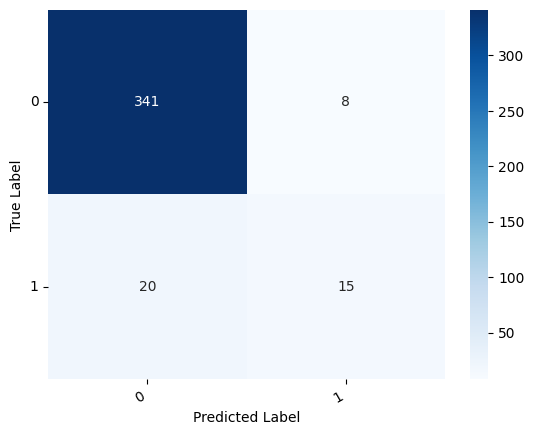

In [47]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

print("Confusion Matrix for BorderlineSMOTE Test Set:")
cm_border = confusion_matrix(y_test1, y_pred_border)
show_confusion_matrix(cm_border)
plt.show()

###CNN + IndoBERT KMeansSMOTE

In [48]:
from tensorflow.keras import backend as K
K.clear_session()
gc.collect()

0

In [49]:
sample_fraction = 0.3
sample_size = int(len(y_res_kmeans) * sample_fraction)

print(f"Total data KMeansSMOTE: {len(y_res_kmeans)}. Mengambil {sample_size} data untuk simple fit.")

Total data KMeansSMOTE: 6274. Mengambil 1882 data untuk simple fit.


In [50]:
indices = np.random.permutation(len(y_res_kmeans))
sample_indices = indices[:sample_size]

x_sample_pad = x_res_pad_kmeans[sample_indices]
x_sample_log = x_res_log_kmeans[sample_indices]
y_sample = y_res_kmeans[sample_indices]

print(f"Running simple fit on a sample of {sample_size} data points")

Running simple fit on a sample of 1882 data points


In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
temp_model_kmeans = create_multichannel_model()
history_kmeans = temp_model_kmeans.fit(
    [x_sample_pad, x_sample_log],
    y_sample,
    batch_size=32,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping_keras],
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6952 - loss: 0.6280 - val_accuracy: 0.9788 - val_loss: 0.0618
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9791 - loss: 0.0726 - val_accuracy: 0.9947 - val_loss: 0.0159
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0309 - val_accuracy: 0.9947 - val_loss: 0.0114
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9956 - loss: 0.0229 - val_accuracy: 0.9947 - val_loss: 0.0095
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9958 - loss: 0.0177 - val_accuracy: 0.9947 - val_loss: 0.0088
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0112 - val_accuracy: 0.9947 - val_loss: 0.0100
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0119 - val_accuracy: 0.9947 - val_loss: 0.0096
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9947 - val_loss

####Cross-Validation Train

In [53]:
# KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
x_train_np_padded = np.array(x_res_pad_kmeans)
x_train_np_logits = np.array(x_res_log_kmeans)
y_train_np = np.array(y_res_kmeans)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
classification_reports_list = []

In [54]:
fold = 0
for train_indices, val_indices in kf.split(x_train_np_padded):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (KMeansSMOTE)")
    model_fold = create_multichannel_model()

    x_train_fold_padded = x_train_np_padded[train_indices]
    x_train_fold_logits = x_train_np_logits[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold_padded = x_train_np_padded[val_indices]
    x_val_fold_logits = x_train_np_logits[val_indices]
    y_val_fold = y_train_np[val_indices]

    model_fold.fit(
        [x_train_fold_padded, x_train_fold_logits], y_train_fold,
        batch_size=32,
        epochs=epochs,
        validation_data=([x_val_fold_padded, x_val_fold_logits], y_val_fold),
        callbacks=[early_stopping_keras],
        verbose=1
    )

    train_loss, train_accuracy = model_fold.evaluate([x_train_fold_padded, x_train_fold_logits], y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate([x_val_fold_padded, x_val_fold_logits], y_val_fold, verbose=0)

    print(f"Fold {fold} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Fold {fold} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy); val_accuracies.append(val_accuracy)
    train_losses.append(train_loss); val_losses.append(val_loss)

    y_pred = (model_fold.predict([x_val_fold_padded, x_val_fold_logits]) > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_list.append(report)
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

    del model_fold
    gc.collect()

Training fold 1/10 (KMeansSMOTE)
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8464 - loss: 0.3402 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 9.5479e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.

In [55]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.9985 (Std: 0.0005)
Mean Training Loss: 0.0056 (Std: 0.0022)
Mean Validation Accuracy: 0.9981 (Std: 0.0016)
Mean Validation Loss: 0.0096 (Std: 0.0072)


In [56]:
if classification_reports_list:
    avg_report_kmeans = {
        '0': { # Menggunakan '0' dan '1' (string) sesuai output dict classification_report
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': { # Menggunakan '0' dan '1' (string)
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }

    # Print the aggregated classification report
    print("Average Classification Report across all folds:")
    import json
    print(json.dumps(avg_report_kmeans, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds:
{
  "0": {
    "precision": 1.0,
    "recall": 0.9962072011059142,
    "f1-score": 0.9980976115791726,
    "support": 3137.0
  },
  "1": {
    "precision": 0.9961617220229322,
    "recall": 1.0,
    "f1-score": 0.9980746827426603,
    "support": 3137.0
  },
  "accuracy": 0.998087394223834,
  "macro avg": {
    "precision": 0.9980808610114661,
    "recall": 0.9981036005529569,
    "f1-score": 0.9980861471609167
  },
  "weighted avg": {
    "precision": 0.9980996432416738,
    "recall": 0.998087394223834,
    "f1-score": 0.9980874417510652
  }
}


In [57]:
csv_file = 'metrics_CNN_IndoBERT_KMeansSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_kmeans.history['loss'])

for epoch in range(num_epochs_ran):
    train_loss = history_kmeans.history['loss'][epoch]
    train_accuracy = history_kmeans.history['accuracy'][epoch]
    val_loss = history_kmeans.history['val_loss'][epoch]
    val_accuracy = history_kmeans.history['val_accuracy'][epoch]
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_CNN_IndoBERT_KMeansSMOTE.csv


####Testing

In [58]:
 evaluation_test1_border = temp_model_kmeans.evaluate(
    [x_test_padded1, non_static_logits_test1],
    y_test1,
    batch_size=32
)
accuracy_test1_border = evaluation_test1_border[1]

print(f"Test Set 1 Evaluation Results (KMeansSMOTE):")
print(f"Loss: {evaluation_test1_border[0]:.4f}, Accuracy: {accuracy_test1_border:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9236 - loss: 0.4734  
Test Set 1 Evaluation Results (KMeansSMOTE):
Loss: 0.4479, Accuracy: 0.9271


In [59]:
# Classification Report for KMeansSMOTE Test Set
y_pred_kmeans = (temp_model_kmeans.predict([x_test_padded1, non_static_logits_test1]) > 0.5).astype("int32").flatten()
print("\nClassification Report for KMeansSMOTE Test Set:")
print(classification_report(y_test1, y_pred_kmeans))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

Classification Report for KMeansSMOTE Test Set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       349
           1       0.65      0.43      0.52        35

    accuracy                           0.93       384
   macro avg       0.80      0.70      0.74       384
weighted avg       0.92      0.93      0.92       384




Confusion Matrix for KMeansSMOTE Test Set:


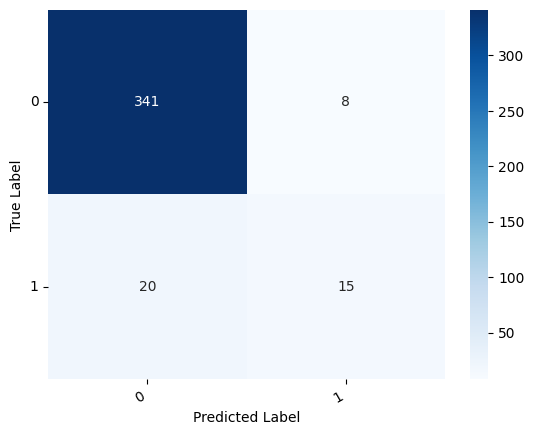

In [60]:
print("\nConfusion Matrix for KMeansSMOTE Test Set:")
cm_kmeans = confusion_matrix(y_test1, y_pred_kmeans)
show_confusion_matrix(cm_kmeans)
plt.show()

###CNN + IndoBERT SVMSMOTE

In [61]:
temp_model_svm = create_multichannel_model()
history_svm = temp_model_svm.fit(
    [x_res_pad_svm, x_res_log_svm],
    y_res_svm,
    batch_size=32,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping_keras],
)
gc.collect()

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8998 - loss: 0.2316 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 4.4680e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 3.5295e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 3.0171e-04
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 2.2281e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 1.6997e-04
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 6.3641e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 

11273

####Cross-Validation Train

In [62]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
x_train_np_padded = np.array(x_res_pad_svm)
x_train_np_logits = np.array(x_res_log_svm)
y_train_np = np.array(y_res_svm)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
classification_reports_list = []

In [63]:
fold = 0
for train_indices, val_indices in kf.split(x_train_np_padded):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (SVMSMOTE)")
    model_fold = create_multichannel_model()

    x_train_fold_padded = x_train_np_padded[train_indices]
    x_train_fold_logits = x_train_np_logits[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold_padded = x_train_np_padded[val_indices]
    x_val_fold_logits = x_train_np_logits[val_indices]
    y_val_fold = y_train_np[val_indices]

    model_fold.fit(
        [x_train_fold_padded, x_train_fold_logits], y_train_fold,
        batch_size=32,
        epochs=epochs,
        validation_data=([x_val_fold_padded, x_val_fold_logits], y_val_fold),
        callbacks=[early_stopping_keras],
        verbose=1
    )

    train_loss, train_accuracy = model_fold.evaluate([x_train_fold_padded, x_train_fold_logits], y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate([x_val_fold_padded, x_val_fold_logits], y_val_fold, verbose=0)

    print(f"Fold {fold} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Fold {fold} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy); val_accuracies.append(val_accuracy)
    train_losses.append(train_loss); val_losses.append(val_loss)

    y_pred = (model_fold.predict([x_val_fold_padded, x_val_fold_logits]) > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_list.append(report)
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

    del model_fold
    gc.collect()

Training fold 1/10 (SVMSMOTE)
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8599 - loss: 0.3177 - val_accuracy: 0.9984 - val_loss: 0.0039
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9968 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9984 - val_loss: 0.0018
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - 

In [64]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.9986 (Std: 0.0006)
Mean Training Loss: 0.0052 (Std: 0.0029)
Mean Validation Accuracy: 0.9979 (Std: 0.0018)
Mean Validation Loss: 0.0091 (Std: 0.0064)


In [65]:
if classification_reports_list:
    avg_report_svm = {
        '0': { # Menggunakan '0' dan '1' (string) sesuai output dict classification_report
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': { # Menggunakan '0' dan '1' (string)
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }

    # Print the aggregated classification report
    print("Average Classification Report across all folds:")
    import json
    print(json.dumps(avg_report_svm, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds:
{
  "0": {
    "precision": 1.0,
    "recall": 0.995885657697554,
    "f1-score": 0.9979355395587444,
    "support": 3137.0
  },
  "1": {
    "precision": 0.9958502139690688,
    "recall": 1.0,
    "f1-score": 0.9979176992110277,
    "support": 3137.0
  },
  "accuracy": 0.9979279045906602,
  "macro avg": {
    "precision": 0.9979251069845343,
    "recall": 0.9979428288487769,
    "f1-score": 0.9979266193848861
  },
  "weighted avg": {
    "precision": 0.9979426471571113,
    "recall": 0.9979279045906602,
    "f1-score": 0.997927934264065
  }
}


In [66]:
csv_file = 'metrics_CNN_IndoBERT_SVMSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_svm.history['loss'])

for epoch in range(num_epochs_ran):
    train_loss = history_svm.history['loss'][epoch]
    train_accuracy = history_svm.history['accuracy'][epoch]
    val_loss = history_svm.history['val_loss'][epoch]
    val_accuracy = history_svm.history['val_accuracy'][epoch]
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_CNN_IndoBERT_SVMSMOTE.csv


####Testing

In [67]:
 evaluation_test1_border = temp_model_svm.evaluate(
    [x_test_padded1, non_static_logits_test1],
    y_test1,
    batch_size=32
)
accuracy_test1_border = evaluation_test1_border[1]

print(f"Test Set 1 Evaluation Results (SVMSMOTE):")
print(f"Loss: {evaluation_test1_border[0]:.4f}, Accuracy: {accuracy_test1_border:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9236 - loss: 0.8597  
Test Set 1 Evaluation Results (SVMSMOTE):
Loss: 0.7731, Accuracy: 0.9271


In [68]:
# Classification Report for SVMSMOTE Test Set
y_pred_svm = (temp_model_svm.predict([x_test_padded1, non_static_logits_test1]) > 0.5).astype("int32").flatten()
print("\nClassification Report for SVMSMOTE Test Set:")
print(classification_report(y_test1, y_pred_svm))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Classification Report for SVMSMOTE Test Set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       349
           1       0.65      0.43      0.52        35

    accuracy                           0.93       384
   macro avg       0.80      0.70      0.74       384
weighted avg       0.92      0.93      0.92       384




Confusion Matrix for SVMSMOTE Test Set:


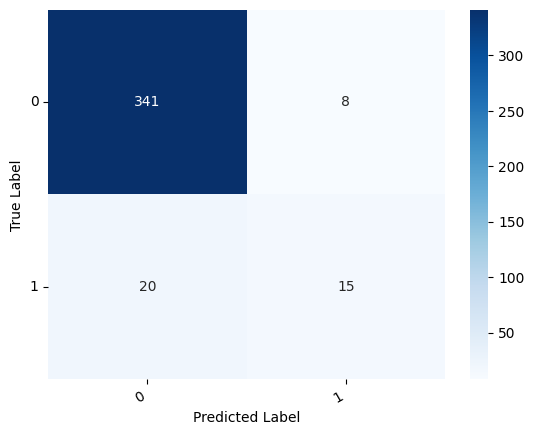

In [69]:
print("\nConfusion Matrix for SVMSMOTE Test Set:")
cm_svm = confusion_matrix(y_test1, y_pred_svm)
show_confusion_matrix(cm_svm)
plt.show()

##Evaluation

###BorderlineSMOTE

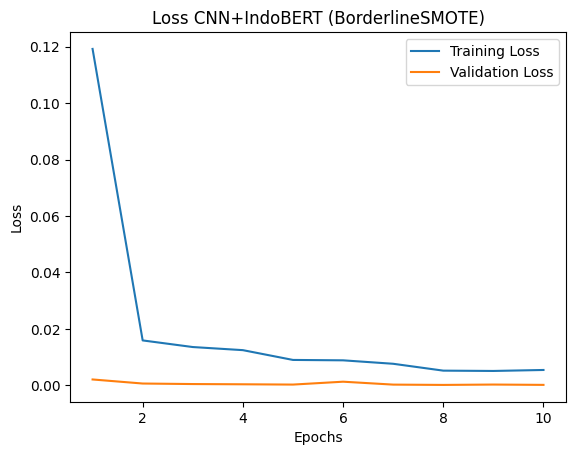

In [70]:
# Plot Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
train_loss = history_borderline.history['loss']
val_loss = history_borderline.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss CNN+IndoBERT (BorderlineSMOTE)')
plt.legend()

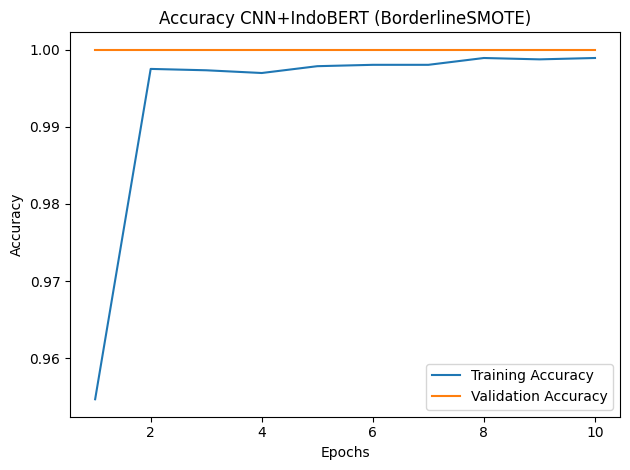

In [71]:
# Plot Accuracy
# plt.subplot(1, 2, 2)
train_accuracy = history_borderline.history['accuracy']
val_accuracy = history_borderline.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy CNN+IndoBERT (BorderlineSMOTE)')
plt.legend()
plt.tight_layout()
plt.show()

###KMeansSMOTE

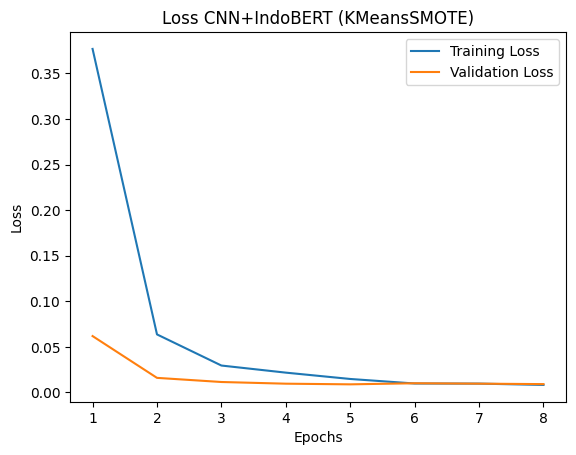

In [72]:
# Plot Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
train_loss = history_kmeans.history['loss']
val_loss = history_kmeans.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss CNN+IndoBERT (KMeansSMOTE)')
plt.legend()

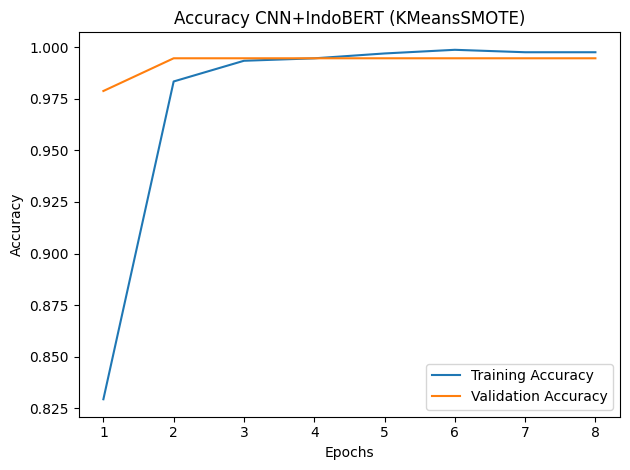

In [73]:
# Plot Accuracy
# plt.subplot(1, 2, 2)
train_accuracy = history_kmeans.history['accuracy']
val_accuracy = history_kmeans.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy CNN+IndoBERT (KMeansSMOTE)')
plt.legend()
plt.tight_layout()
plt.show()

###SVMSMOTE

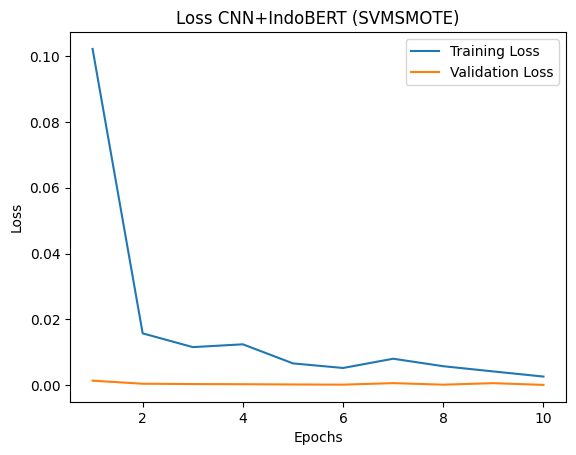

In [74]:
# Plot Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
train_loss = history_svm.history['loss']
val_loss = history_svm.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss CNN+IndoBERT (SVMSMOTE)')
plt.legend()

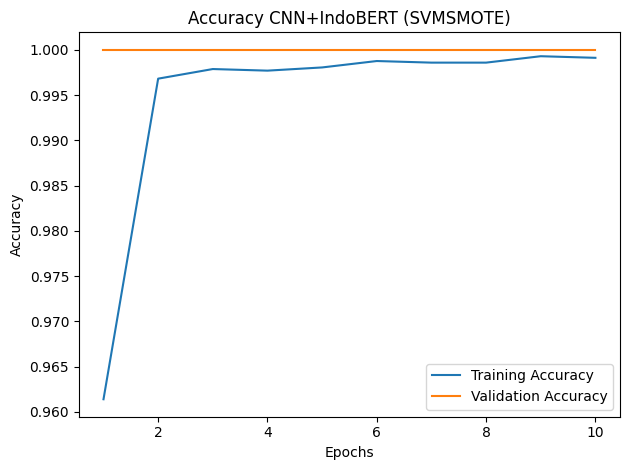

In [75]:
# Plot Accuracy
# plt.subplot(1, 2, 2)
train_accuracy = history_svm.history['accuracy']
val_accuracy = history_svm.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy CNN+IndoBERT (SVMSMOTE)')
plt.legend()
plt.tight_layout()
plt.show()